## Небольшое дополнение

Теплоемкость расчитывается по следующему полиному

$$Cp(T)/R = a_1 * T^{-2} + a_2 * T^{-1} + a_3 + a_4 * T + a_5 * T^2 + a_6 * T^3 + a_7 * T^4$$

Коэффициенты для:
* Воздух от 200 до 1000 K:
1.009950160e4,-1.968275610e2, 5.009155110,
                -5.761013730e-3,
                1.066859930e-5,
                -7.940297970e-9,
                 2.185231910e-12
* Воздух от 1000 до 2000 K:
2.415214430e+05,-1.257874600e+03, 5.144558670e+00,-2.138541790e-04, 7.065227840e-08,
-1.071483490e-11, 6.577800150e-16, 

* Вода от 200 до 1000K:

-3.947960830e+04, 5.755731020e+02, 9.317826530e-01, 7.222712860e-03,-7.342557370e-06,
     4.955043490e-09,-1.336933246e-12 

* Вода от 1000 до 2000K:
1.034972096e+06,-2.412698562e+03, 4.646110780e+00, 2.291998307e-03,-6.836830480e-07,
 9.426468930e-11,-4.822380530e-15 
 
* N2 от 200 до 1000 K:
2.210371497e4, -3.818461820e2,   6.082738360,
                   -8.530914410e-3,
                    1.384646189e-5,
                    -9.625793620e-9, 2.519705809e-12, 
                    
* N2 от 1000 до 2000 K:                 
5.877124060e+05, -2.239249073e+03, 6.066949220e+00, -6.139685500e-04,
                 1.491806679e-07,-1.923105485e-11, 1.061954386e-15
                 
* Трехатомные газы от 200 до 1000 K:
4.943650540e+04,-6.264116010e+02,
               5.301725240,
                2.503813816e-03,
                -2.127308728e-07,
                -7.689988780e-10,
                 2.849677801e-13
* Трехатомные газы от 1000 до 6000K:
1.176962419e+05, -1.788791477e+03, 8.291523190e+00,-9.223156780e-05,4.863676880e-09,
-1.891053312e-12, 6.330036590e-16

Теплоемкость смеси продуктов сгорания и воздуха

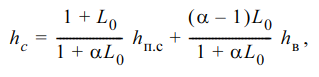

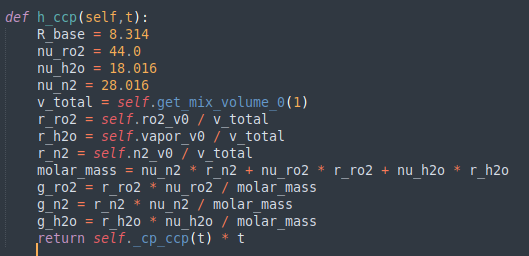

# Задача 

Для  расчета  тепловой  схемы  простой ГТУ  заданы  или  приняты  по  оценке  следующие  исходные величины:
* электрическая мощность Nэ = 100 МВт
* температура газов перед турбиной tc = 1200 °С
* температура воздуха на входе в компрессор ta = 15 °С
* отношение давлений компрессора ε = pb/pa = 16
* коэффициент потерь давления λ = δ/ε = 0,95
* коэффициент  использования  теплоты  топлива  в камере сгорания ηк.c = 0,995
* механический КПД турбины ηм = 0,995
* КПД электрического генератора ηэ.г = 0,982
* изоэнтропийный КПД турбины ηт = 0,88
* изоэнтропийный КПД компрессора ηк = 0,8

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append("..")
from natural_gas.gas import NaturalGas

In [3]:
kPa = 1e3
MPa = 1e6
MW = 1e6

to_kelvin = lambda x: x + 273.15
to_celsius = lambda x: x - 273.15

In [4]:
electrical_power = 100 * MW
T_c = to_kelvin(1200)
T_a = to_kelvin(15)
p_a = 101 * kPa
pressure_loss_coefficient = 0.95
compression_factor = 16

fuel_density = 0.7325
air_density = p_a / (287 * T_a)
rho = fuel_density / air_density


combustor_efficiency = 0.995
mechanical_efficiency = 0.995
generator_efficiency = 0.982
compressor_efficiency = 0.86
turbine_efficiency = 0.88

R_air = 287

In [5]:
gas = NaturalGas()

L0 = gas.air_v0 / rho
Q_lower = gas.net_calorific_value * 1000 / fuel_density 
L0, Q_lower

(15.64649112920197, 48205632.76450512)

In [6]:
m_air = R_air / gas._cp_air(T_a)
h_a = gas.h_air(T_a)

In [7]:
T_b = T_a * (1 + (compression_factor ** m_air - 1) / compressor_efficiency)
print("Температура за компрессором в первом приближении: ", to_celsius(T_b))

Температура за компрессором в первом приближении:  420.68132642074943


In [8]:
h_b = gas.h_air(T_b)
# cp_air_mean = (gas._cp_air(T_a) + gas._cp_air(T_b)) / 2 
cp_air_mean = (h_b - h_a) / (T_b - T_a) 
m_air_precise = R_air / cp_air_mean
m_air_precise

0.27856065860225204

In [9]:
T_b = T_a * (1 + (compression_factor ** m_air_precise - 1) / compressor_efficiency)
h_b = gas.h_air(T_b)
print("Температура за компрессором:", to_celsius(T_b))

Температура за компрессором: 405.28019049905345


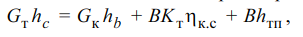

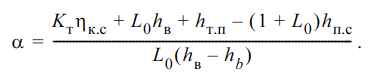

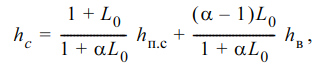

In [10]:
h_air_tc = gas.h_air(T_c) / 1000
h_ccp = gas.h_ccp(T_c) / 1000

alpha = (
    (Q_lower / 1000) * combustor_efficiency +
    L0 * h_air_tc -
    (1 + L0) * h_ccp
) / (L0 * (h_air_tc - h_b/1000))

# alpha = (3000 - 0.367 * T_c) / (T_c - T_b)

alpha

2.3278039434010185

In [11]:
gas = NaturalGas(alpha=alpha)

In [12]:
h_c = gas.h_cp(T_c, alpha=alpha, L0=L0)
h_c

1664031.0277754338

In [13]:
m_gas = 0.25

In [14]:
expansion_ratio = compression_factor * pressure_loss_coefficient
expansion_ratio

15.2

In [15]:
T_d = T_c * (1 - (1 - expansion_ratio ** (-m_gas)) * turbine_efficiency)
print("Температура за турбиной в первом приближении: ", to_celsius(T_d))

Температура за турбиной в первом приближении:  560.1794204434805


In [16]:
h_d = gas.h_cp(T_d, alpha, L0)

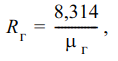

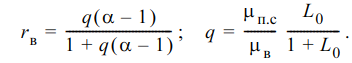

In [17]:
nu_ccp = 8.313 / gas.R_cp * 1000
nu_air = 29

In [18]:
q = (nu_ccp * L0) / (nu_air * (1 + L0))
r_frac = q * (alpha - 1) / (1 + q * (alpha - 1))
nu_gas = nu_air * r_frac + nu_ccp * (1 - r_frac)
R_gas = 8.314 * 1000 / nu_gas
R_gas

293.6506950683933

In [19]:
Cp_gas = (h_c - h_d) / (T_c - T_d)
m_gas = R_gas / Cp_gas
m_gas

0.21355884342157147

In [20]:
T_d = T_c * (1 - (1 - expansion_ratio ** (-m_gas)) * turbine_efficiency)
print("Температура за турбиной: ", to_celsius(T_d))

Температура за турбиной:  628.6254724563363


In [21]:
h_d = gas.h_cp(T_d, alpha, L0)

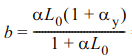

In [22]:
b = alpha * L0 * (1 + 0) / (1 + alpha * L0)

In [23]:
H_turbine = h_c - h_d
H_compressor = h_b - h_a
H_work = H_turbine * mechanical_efficiency - b * H_compressor

In [24]:
gas_mass_flow = electrical_power / (H_work * generator_efficiency)
gas_mass_flow

257.5350389827711

In [25]:
air_mass_flow = b * gas_mass_flow
air_mass_flow

250.65311689293247

In [26]:
fuel_mass_flow = gas_mass_flow / (1 + alpha * L0)
fuel_mass_flow

6.881922089838615

In [27]:
turbine_power = gas_mass_flow * H_turbine
compressor_power = air_mass_flow * H_compressor

In [28]:
work_coefficient = (turbine_power - compressor_power) / turbine_power
work_coefficient

0.5054445390455233

In [29]:
electrical_efficiency_estimated = (
    gas_mass_flow * H_work * generator_efficiency / (fuel_mass_flow * Q_lower)
)
electrical_efficiency_estimated

0.3014341553064689